## Trying to get un-stuck on a seemingly simple ODE  problem

In [12]:
# using JuMP
# using Ipopt
using DataFrames, CSV
using Plots
# using DifferentialEquations
using OrdinaryDiffEq
using Distributions
using NLsolve
using ForwardDiff
using SpecialFunctions 

include("fast_quadprog.jl")


quadprog_exactSolve (generic function with 2 methods)

In [13]:
using ForwardDiff

mutable struct Bid{T1,T2,T3,T4}
    init_index::Int64
    a::T1
    b::T2
    q::T3
    a_over_q::T4
end

function quadprog_exactSolve(a,b,q, s, detail = false)
    num_bids = length(a)
    bidvec = [Bid(i, a[i],b[i],q[i],(a[i]/q[i])) for i=1:num_bids ]
    sorted_bids = sort(bidvec, by = x -> x.a_over_q, rev=true)
    
    if detail
        println("sorted_bids: ")
        for bid in sorted_bids
            println(bid)
        end
        
    end
    
    ## Save sorted vector for faster calculations
    sorted_a = [sorted_bids[i].a for i=1:num_bids]
    sorted_b = [sorted_bids[i].b for i=1:num_bids]
    sorted_q = [sorted_bids[i].q for i=1:num_bids]
    min_sorted_a_over_q = [-sorted_bids[i].a_over_q for i=1:num_bids]
#     min_sorted_a_over_q_nxt = map(_->zero(float(s)), sorted_a)
    min_sorted_a_over_q_nxt = map(x->zero(float(x)), sorted_a)
#     @show min_sorted_a_over_q_nxt = [0.0 for i = 1:num_bids]
    
    for i=1:(num_bids-1)
        min_sorted_a_over_q_nxt[i] = min_sorted_a_over_q[i+1]
    end
    min_sorted_a_over_q_nxt[num_bids] = Inf


    ## Compute v_ks
    t1 = sorted_a .* sorted_q ./ sorted_b
    t2 = sorted_q.^2 ./ sorted_b
    t1_acc = accumulate(+, t1)
    t2_acc = accumulate(+, t2)
    
    ## Set v_ks and handle cases where b_i = 0
    xst_try = (2*s .- t1_acc) ./ t2_acc
    v_ks = copy(xst_try)
    v_ks = replace!(v_ks, NaN => Inf) 
    
    
    for i=1:(num_bids)
        v_ks[i] = sorted_b[i] <= 0 ? min_sorted_a_over_q[i] : min.(xst_try[i], min_sorted_a_over_q_nxt[i])
        if sorted_b[i] <= 0 ## only want to set the _first_ non-quad b
            break
        end
    end
    
    ## Compute duals
    function dual_eval(v)
#         x_stars = [0.0 for  i=1:num_bids]
#         x_stars = map(x->zero(float(x)), sorted_a)
        x_stars = map(x->zero(float(eltype(v))), 1:num_bids)
        dual_eval = 0.
        cum_qx = 0.
        for i=1:num_bids
            if min_sorted_a_over_q[i] > v
                break
            end
            if sorted_b[i] <= 0.
                x_stars[i] = (s-cum_qx)/sorted_q[i] 
                dual_eval += ( (sorted_a[i]/sorted_q[i]) + v ) * (s - cum_qx)
                break
            else
                x_stars[i] = ( (sorted_a[i] + (v * sorted_q[i]) ) / (2 * sorted_b[i]) )
                dual_eval += ( (sorted_a[i] + (v * sorted_q[i]) )^2 / (4 * sorted_b[i]) )
                cum_qx +=  sorted_q[i]*x_stars[i]
            end
        end

        out = dual_eval - v*s
        return(out, x_stars)
    end
    
    duals = [dual_eval(v_k) for v_k in v_ks]
    
    
    if detail
        println("v_ks: ", v_ks)
        println("dual obj: ", [duals[i][1] for i=1:length(duals)])
    end
    
    ## check corner solutions
    function getCornerObj(i)
        x_i_st = s / sorted_q[i]
        obj = sorted_a[i]*x_i_st - sorted_b[i]*(x_i_st^2)
        return((obj,i))
    end
    
    corner_vals = [getCornerObj(i) for i=1:num_bids]

    
    sort!(duals, by = x -> x[1])
    sort!(corner_vals, by = x -> x[1], rev=true)

    duals_opt = duals[1]
    corners_opt = corner_vals[1]
    
    if duals_opt[1] >= corners_opt[1]
        opt_val = duals_opt[1]
        x_star_sorted = duals_opt[2]
    elseif s <= 0
#         x_star_sorted = map(x->zero(float(eltype(s))), 1:num_bids)
        x_star_sorted = map(_->zero(float(s)), sorted_a)
    else
        opt_val = corners_opt[1]
        opt_i = corners_opt[2]
        x_star_sorted = map(_->zero(float(s)), sorted_a)
#         x_star_sorted = map(x->zero(float(eltype(s))), 1:num_bids)
        x_star_sorted[opt_i] = (s / sorted_q[opt_i])
    end
    x_star_orig_order = copy(x_star_sorted)
    for i = 1:num_bids
        bid = sorted_bids[i]
        x_star_orig_order[bid.init_index] = x_star_sorted[i]
    end
    
    return(x_star_orig_order)
    
end

quadprog_exactSolve (generic function with 2 methods)

### Note: 
The `fast_quadprog.jl` file can be found [here](https://github.com/shoshievass/PublicFiles/blob/master/Julia/fast_quadprog.jl).

### Overview
This notebook details a "simple" procurement auction equilibrium computation, for auctions of the form described [here](https://scholar.harvard.edu/files/vasserman/files/bv_sept2019.pdf).

For some shorter notes working out the math for this example in full see [here](https://github.com/shoshievass/PublicFiles/blob/master/Julia/baseline_equilibrium_derivation_risk_aversion_note.pdf). For a better high-level explanation of what's going on, aimed at extending this model to a two-dimensional type version, see [here](https://github.com/shoshievass/PublicFiles/blob/master/Julia/asymmetric_two_type_problem.pdf).

I present the ODE and a working solution, using an upper bound as an initial condition. I then try to solve the ODE in the "inverse", using a guessed lower bound as an initial condition. 

The reason for trying to solve the inverse problem is that I ultimately want to solve a boundary-value problem where two ODEs of this form need to be solved simultaneously subject to having the same values at the boundaries. One way to try to solve the boundary value problem is to use a shooting algorithm in which I solve the two inverse ODE problems with guessed initial values and check if they match at the upper boundary.

Currently, the inverse problem doesn't work -- most likely for numerical reasons that I don't understand.

### The ODE

The ODE problem maps a bounded interval of "types" $\alpha \in \left[ \underline{\alpha}, \overline{\alpha} \right]$ to "scores" $s \in \left[ \underline{s}, \overline{s} \right]$ according to the differential equations:

$$
s'(\alpha) = \frac{f(\alpha)}{1-F(\alpha)} \cdot \frac{V(s, \alpha, p)}{V'(s , \alpha, p)}
$$

Here:
- $f(\alpha)$ and $F(\alpha)$ are the pdf and cdf of the distrubiton with which the types $\alpha$ are distributed -- which we will assume is a uniform distribution for simplicity. 

- That is, $f(x) = \frac{1}{\overline{\alpha} - \underline{\alpha}}$ and $F(x) = \frac{x - \underline{\alpha}}{\overline{\alpha} - \underline{\alpha}}$ 

- $ V(s , \alpha, p) $ is a "value function" evaluated at $s, \alpha$ and a vector of parameters $p$. More details on this in a bit.

- $V'(s , \alpha, p) = \frac{\partial V}{\partial s} V(s , \alpha, p)$ is the derivative of the value function with respect to s.

### Multiple (Asymmetric) Gamma Problem

The problem described above has an additional latent parameter that is treated as fixed: $\gamma$. 

For my current endeavor, I need to solve a closely related problem where there are multiple types of $\gamma$. The tricky thing is that in order for each $\gamma$ type's ODE to be well defined, they need to be "in equilibrium with each other".

#### The Problem Definition

There are $N=2$ types of bidders $i$, each of whom has some value of $\gamma$. 

We are interested in solving for the "equilibrium bidding" function that maps each possible type $(\tilde{\alpha}, {\gamma}_i)$ to a "score" $s_i(\tilde{\alpha}, {\gamma}_i)$. 

We can think the "score" function as a map:
$$
s_i : [\underline{\alpha}, \overline{\alpha}] \rightarrow [\underline{S}, \overline{S}]
$$

where each of $[\underline{\alpha}, \overline{\alpha}]$ and $[\underline{S}, \overline{S}]$ are subsets of $\mathbb{R}_{+}$. 

In order for a prospective "score" function to be an equilibrium, it needs maximize the "expected utility" from participating in the auction for each possible bidder type $(\tilde{\alpha}, \tilde{\gamma})$ --- let's call this $EU(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha}))$.

This is the product of the (expected) utility that the bidder would get from completing the project if he wins (given his bid) times the probability that he wins.

$$
EU_i(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha}, {\gamma}_i)) = \text{E}[u(\pi(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha}, {\gamma}_i))) \text{ | win}] \times \text{Pr(win | } s_i(\tilde{\alpha}) \text{ )}
$$


The rules of the auction are that the bidder with the **lowest** score wins the auction. Thus, we can write 
$$
\text{Pr(win | } s(\tilde{\alpha}, \tilde{\gamma}) \text{ )} = \text{Pr(} s(\tilde{\alpha}, \tilde{\gamma}) < \text{ all other bidders' scores)}
$$

That is, the probability that bidder $i$ will win using a score $s_i(\tilde{\alpha})$ is the probability that the other bidder $j$ will bid a higher score than that.

**Crucially** in equilibrium, the bidders are "best responding" to each other's score functions. 

That is:
$$
\text{Pr(} s(\tilde{\alpha}, \tilde{\gamma}) < \text{ all other bidders' scores)} = 
\text{Pr(} s_i(\tilde{\alpha}) < s_j(\alpha_j) \text{ )} \\ =
\text{Pr(} s_j^{-1}(s_i(\tilde{\alpha})) < \alpha_j \text{ )}
$$

where $\alpha_j$ is an IID random draw from the distribution of $\alpha$.

Writing $$
V(s, \hat{\alpha}, \gamma_i, p) \equiv \text{E}[u(\pi(\tilde{\alpha}, {\gamma}_i, s_i(\hat{\alpha}))) \text{ | win}]
$$
for notational ease, we can rewrite the expected utility equation above:

$$
EU_i(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha})) = V_i(s, \hat{\alpha}, \gamma_i, p) \times \text{Pr(} s_j^{-1}(s_i(\tilde{\alpha})) < \alpha_j \text{ )}.
$$

We can then derive the system of differential equations by taking the first order condition:

### Boundary Value Problem ODE Definition

Denote $\psi_i(\tilde{s}) = s_i^{-1}(\tilde{s})$ for the inverse function of the mapping $s_i$.

$$
\psi_i'(s_j) = \frac{1-F(\psi_i(s_j))}{f(\psi_i(s_j))} \cdot \frac{V(s_j, \alpha_j, p)}{V'(s_j , \alpha_j, p)}
$$

and

$$
\psi_j'(s_i) = \frac{1-F(\psi_j(s_i))}{f(\psi_j(s_i))} \cdot \frac{V(s_i, \alpha_j, p)}{V'(s_i , \alpha_i, p)}
$$

where:
- $f(\alpha)$ and $F(\alpha)$ are the pdf and cdf of the distrubiton with which the types $\alpha$ are distributed -- which we will assume is a uniform distribution for simplicity. 

- That is, $f(x) = \frac{1}{\overline{\alpha} - \underline{\alpha}}$ and $F(x) = \frac{x - \underline{\alpha}}{\overline{\alpha} - \underline{\alpha}}$ 

- $ V(s , \alpha, p) $ is a "value function" evaluated at $s, \alpha$ and a vector of parameters $p$. More details on this in a bit.

- $V'(s , \alpha, p) = \frac{\partial V}{\partial s} V(s , \alpha, p)$ is the derivative of the value function with respect to s.

#### Boundary Conditions

What makes this a boundary problem is:
1. The ODEs for $i$ and $j$ have to be solved together
2. Both boundary scores have to be the same: 

$$
\psi_i(\overline{S}) = \psi_j(\overline{S}) = \overline{\alpha} \text{ and } \psi_i(\underline{S}) = \psi_j(\underline{S}) = \underline{\alpha}
$$
or equivalently:
$$ 
s_i(\overline{\alpha}) = s_j(\overline{\alpha}) \text{  and  } s_i(\underline{\alpha}) = s_j(\underline{\alpha})
$$
3. There is a known initial condition that (supposing that $\gamma_j < \gamma_i$): 
    - $s_i(\overline{\alpha})$ must be the smallest value of $s$ s.t. $V(s , \overline{\alpha}, p) = 0$

In [14]:
function ds_da_ode( s, γ, α, params)
        
#     f_over_oneMinusF = f_over_F_uniform(α, 0.5, 2.0)
    f_over_oneMinusF = f_over_one_minus_F_lognormal_dist(α, 0., 0.12, 0.5, 2.01)

    V_over_dV = getFracVdV(s, γ, α, params)
    
    ds_da = f_over_oneMinusF * V_over_dV; # Note: this should be a scalar
    
    return(ds_da)

end

ds_da_ode (generic function with 1 method)

#### More Details

- Note that $\frac{f(\alpha)}{1-F(\alpha)}$ must be zero outside the support of $\alpha$. We define this below.

- The value function here is a bit complicated -- it requires solving a (simple) constrained quadratic formula to define:

$$
\begin{array}{c}V(s , \alpha, \mathbf{p}) = \arg\max\limits_{\{{b_t}(s)\}_t} \left[1-\exp \left(\sum_{t=1}^{T} \frac{\gamma^{2} \sigma_t^{2}}{2}\left(b_{t}(s)-\alpha c_{t}\right)^{2}-\gamma q_{t}^{a}\left(b_{t}(s)-\alpha c_{t}\right)\right)\right] \\ \text { s.t. } \sum_{t=1}^{T} b_{t}(s) q_{t}^{e}=s \\ \text { and } b_{t} \geq 0 \text { for each } t\end{array}
$$

where the parameter vector $ \mathbf{p}$ includes a whole bunch of parameters: $$ \mathbf{p} = \Big\{ \gamma, \{q_{t}^{a}\}_t,  \{q_{t}^{e}\}_t,\{\sigma_{t}^{2}\}_t \text{ and }  \{c_{t}\}_t  \Big\}$$

But we can solve this problem numerically for the vector of "bids" $b_{t}^{\ast}(s)$. Note that the optimal $b^{\ast}$ solution depends not just on $s$ but on $\alpha$ and all of the other parameters too, but we will keep everything except $s$ and $\alpha$ fixed for our ODE computation and for each $\alpha$ we will choose a single $s$.

In [15]:
function f_over_one_minus_F_uniform(z, a, b)
    if z < a 
        out = 0
    elseif z >= b
        out = 0
    else 
        out =  1.0/(b - z) 
    end
end

function f_over_one_minus_F_truncated_lognormal(z, mu, sigma, a, b)
    
    if z < a
        out_fin = 0
    elseif z > b
        out_fin = 0
    else 
        out = 0.5*sqrt(2)*sqrt(pi)*sigma*z
        out = out * (-erf(sqrt(2)*(mu - log(b))/(2*sigma)) + 1.0*erf(sqrt(2)*(mu - log(z))/(2*sigma)))
        out = out * exp((mu - log(z))^2/(2*sigma^2))
        out_fin = 1.0/(out - 0.0000001)

    end
    return(out_fin)
end

function f_over_one_minus_F_lognormal_dist(z, mu, sigma, a, b)
    alpha_dist = LogNormal(mu,sigma)

    f(x) = pdf(alpha_dist, x);
    F(x) = cdf(alpha_dist, x);
    
    out = (f(z) ./ (1 - F(z) - 0.000000001))
    
    return(out)
end

function getBidStar(s, γ, α, params)
    c, q_e, q_a, sigma_sq  = params
    
    T = length(q_e)
    
    b_tilde =  (γ .* 0.5) .* sigma_sq 
    a_tilde = (q_a .+ (γ .* α .* c) .* sigma_sq)
    s_tilde = s
    q_tilde = q_e
    
    sol = quadprog_exactSolve(a_tilde,b_tilde,q_tilde,s_tilde)
    
    return(sol)
end


function getDbDs_ForwardDiff(s, γ, α, params)
#     %Computes anayltical derivative of the optimal bid function of item t
#     % w.r.t. score s given α

    b_opt_of_s = x -> getBidStar(x, γ, α, params) ## change order
    
    db_ds = ForwardDiff.derivative(b_opt_of_s, s)

    return(db_ds)

end

function getDbDs(s, γ, α, b, params)
#     %Computes anayltical derivative of the optimal bid function of item t
#     % w.r.t. score s given alpha
    
    c, q_e, q_a, sigma_sq  = params

    T = length(q_e)
    pos_b = [ifelse(b[t] > 0, 1, 0) for t=1:T]

    if (sum(sigma_sq) > 0)
        denom = 1.0/(sum((q_e[t]^2 * pos_b[t]) / sigma_sq[t] for t in 1:T))
        db_ds = [((q_e[t] * pos_b[t] / sigma_sq[t]) * denom) for t in 1:T]'
    else
        db_ds = [ifelse(b[t] > 0, (1.0/q_e[t]), 0) for t=1:T]'
    end

    return(db_ds)

end

function getFracVdV(s, γ, α, params)
    
    c, q_e, q_a, sigma_sq  = params
                                                                
    b = getBidStar( s, γ, α, params)
#     db_ds = getDbDs_ForwardDiff(s, γ, α, params)
    db_ds = getDbDs( s, γ, α, b, params)

    b_min_c = b - (α*c);

    profit_ce = (q_a' * b_min_c) - (γ)*0.5 * ((sigma_sq .* b_min_c)' * b_min_c)
        
    profit_term = exp(γ*profit_ce) - 1; 
    
    dce = db_ds * ((γ .* q_a) - (γ^2 .* sigma_sq .* b_min_c) );
        
    V_over_dV = profit_term / dce;
    
    return(V_over_dV)
    
end


getFracVdV (generic function with 1 method)

### Adding a Boundary Condition

To fully define this ODE problem we need an initial condition. For this problem, there is one point at which we know the solution: the "right" boundary.

From the economic theory, we must have the highest type of bidder, $\overline{\alpha}$ gets a value of zero at the solution: $V(s(\overline{\alpha}), \overline{\alpha}, p) = 0.$

Because $V(s, \alpha, p)$ doesn't have a closed form solution, we must solve for this upper bound numerically as well, by searching over the values of $s$ to find:

$$
\overline{s} = \arg\min\limits_{s} \big\{s : V( s, \overline{\alpha}, p) = 0 \big\}
$$

In [16]:
function getInsideV(s, γ, α, params)
    c, q_e, q_a, sigma_sq  = params
    
    b = getBidStar( s, γ, α, params)    

    b_min_c = b - (α*c);

    ce = (q_a' * b_min_c) - (γ*0.5) * ((sigma_sq .* b_min_c)' * b_min_c)
end

function getBoundarySMax( γ, α, params)
    c, q_e, q_a, sigma_sq  = params
    
    function ce_fun(svec)
        s_max_var = svec[1]
        ce = getInsideV(s_max_var, γ, α, params) 
        return (ce^2)
    end
    
    starting_point = α*1.1*(c' * q_a)

    s_max_sol = nlsolve(ce_fun, [starting_point]; inplace = false)
    return s_max_sol.zero[1]
end

getBoundarySMax (generic function with 1 method)

### Solving an easy example -- This used to work!

s_max_computed = getBoundarySMax(γ0, alpha_max, params0) = 13.772885478995562


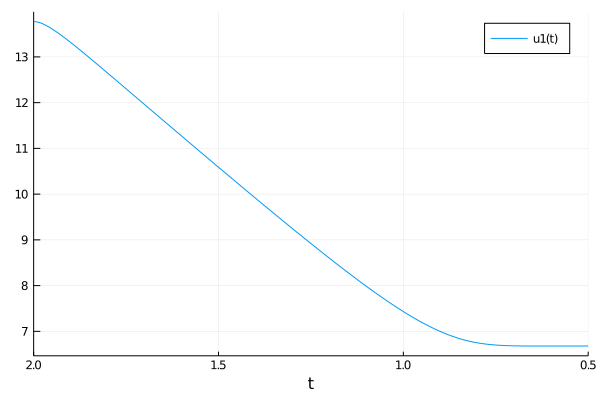

In [20]:
qa0 = [1.; 4.];
qe0 = [1.; 5.];
c0 = [0.5;1.3];
sigmasq0 = [0.2; 0.4];
γ0 = 0.5;


params0 = [c0, qe0, qa0, sigmasq0]

alpha_max = 2.0;
alpha_min = 0.5;

alpha_span = (alpha_max,alpha_min);


@show s_max_computed = getBoundarySMax(γ0, alpha_max, params0)

ode_standard_subs(s, p, α) = ds_da_ode( s, γ0, α, params0 )
ode_standard_prob = ODEProblem(ode_standard_subs, s_max_computed, alpha_span)

sol_standard =  OrdinaryDiffEq.solve(ode_standard_prob, Rosenbrock23())

plot(sol_standard)

## Solving in Reverse -- This also sometimes works?


s_min_guess: 6.678379973752892


┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /Users/svass/.julia/packages/DiffEqBase/T5smF/src/integrator_interface.jl:349


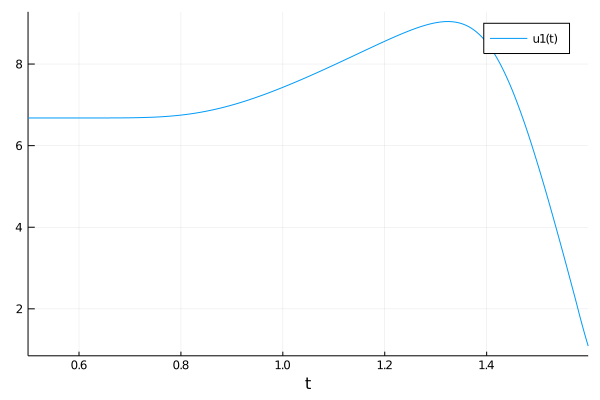

In [22]:

# alpha_span = (alpha_max,alpha_min);
alpha_span_reverse = (0.5, alpha_max);

s_min_from_forward_solve = sol_standard[end] 

s_min_guess = s_min_from_forward_solve
println("s_min_guess: ", s_min_guess)

ode_reverse_subs(s, p, α) = ds_da_ode( s, γ0, α, params0 )
ode_reverse_prob = ODEProblem(ode_reverse_subs, s_min_guess, alpha_span_reverse)

sol_reverse =  OrdinaryDiffEq.solve(ode_reverse_prob, Rosenbrock23())
plot(sol_reverse)

In [23]:
## For testing
α0 = 0.8
qa0 = [1.; 4.];
qe0 = [1.; 5.];
c0 = [.5;1.];
sigmasq0 = [0.2, 0.4];

params0 = [c0, qe0, qa0, sigmasq0]

s0 = 4.5
getInsideV(s0, γ0, α0, params0)

# # getInsideV(s0, γ0, α0, params)
alpha_max = 2;
alpha_min = 0.5;

γmin = 0.5;
γmax = 0.75;


@show s_min_alpha_min_gamma_min = getBoundarySMax( γmin, alpha_min, params0)
@show s_min_alpha_max_gamma_min = getBoundarySMax( γmin, alpha_max, params0)

@show getBidStar( s_min_alpha_min_gamma_min, γmin, alpha_min, params0)
@show getBidStar( s_min_alpha_max_gamma_min, γmin, alpha_max, params0)


@show s_min_alpha_min_gamma_max = getBoundarySMax( γmax, alpha_min, params0)
@show s_min_alpha_max_gamma_max = getBoundarySMax( γmax, alpha_max, params0)


s_min_alpha_min_gamma_min = getBoundarySMax(γmin, alpha_min, params0) = 2.522867859125154
s_min_alpha_max_gamma_min = getBoundarySMax(γmin, alpha_max, params0) = 10.772854168201475
getBidStar(s_min_alpha_min_gamma_min, γmin, alpha_min, params0) = [2.085027248824085, 0.08756812206021536]
getBidStar(s_min_alpha_max_gamma_min, γmin, alpha_max, params0) = [2.835026234681591, 1.5875655867039784]
s_min_alpha_min_gamma_max = getBoundarySMax(γmax, alpha_min, params0) = 2.5985201036670724
s_min_alpha_max_gamma_max = getBoundarySMax(γmax, alpha_max, params0) = 10.8485237541349


10.8485237541349

In [24]:
## For testing
α0 = 0.8
# qa0 = [1.; 4.];
# qe0 = [1.; 5.];
# c0 = [.5;1.];
# sigmasq0 = [0.2, 0.4];
# # γ0 = 0.5;

qa0 = [12; 40];
qe0 = [10; 50];
c0 = [5;10];
sigmasq0 = [3, 5];

alpha_max = 2;
alpha_min = 0.5;

γmin = 0.05;
γmax = 0.075;


params0 = [c0, qe0, qa0, sigmasq0]

s0 = 4000.5
getInsideV(s0, γ0, α0, params0)

# # getInsideV(s0, γ0, α0, params)
alpha_max = 2;
alpha_min = 0.5;

γmin = 0.05;
γmax = 0.075;


@show s_min_alpha_min_gamma_min = getBoundarySMax( γmin, alpha_min, params0)
@show getBidStar( s_min_alpha_max_gamma_min, γmin, alpha_max, params0)

println()

@show s_min_alpha_max_gamma_min = getBoundarySMax( γmin, alpha_max, params0)
@show getBidStar( s_min_alpha_min_gamma_min, γmin, alpha_min, params0)

println()


@show s_min_alpha_min_gamma_max = getBoundarySMax( γmax, alpha_min, params0)
@show getBidStar( s_min_alpha_min_gamma_max, γmax, alpha_min, params0)

println()


@show s_min_alpha_max_gamma_max = getBoundarySMax( γmax, alpha_max, params0)
@show getBidStar( s_min_alpha_max_gamma_max, γmax, alpha_max, params0)

# @show getFracVdV(s_min_alpha_max_gamma_max, γmax, alpha_max, params0)
# @show ds_da_ode(s_min_alpha_max_gamma_max, γmax, alpha_max, params0)

# @show getDbDs_ForwardDiff(s_min_alpha_max_gamma_max, γmax, alpha_max, params0)

# @show ds_da_ode(s_min_alpha_max_gamma_max, γmax, alpha_max, params0)
# @show ds_da_ode_old( s_min_alpha_max_gamma_max, γmax, alpha_max, params0 )

s_min_alpha_min_gamma_min = getBoundarySMax(γmin, alpha_min, params0) = 217.4091927855693
getBidStar(s_min_alpha_max_gamma_min, γmin, alpha_max, params0) = [1.0772854168201476, 0.0]

s_min_alpha_max_gamma_min = getBoundarySMax(γmin, alpha_max, params0) = 1039.601107266888
getBidStar(s_min_alpha_min_gamma_min, γmin, alpha_min, params0) = [21.740919278556923, 0.0]

s_min_alpha_min_gamma_max = getBoundarySMax(γmax, alpha_min, params0) = 234.73421138800612
getBidStar(s_min_alpha_min_gamma_max, γmax, alpha_min, params0) = [18.91500548784171, 0.9116831301917993]

s_min_alpha_max_gamma_max = getBoundarySMax(γmax, alpha_max, params0) = 1059.7340501400388
getBidStar(s_min_alpha_max_gamma_max, γmax, alpha_max, params0) = [26.415004480041915, 15.911680106792403]


2-element Array{Float64,1}:
 26.415004480041915
 15.911680106792403